# Non-convex optimization - application to matrix completion
In this notebook, we define matrix completion problems and we implement a (naive) algorithm to solve it through non-convex optimization.

In [1]:
from enum import Enum
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

## Matrix completion
Matrix completion is the problem of recovering a matrix $M\in \mathbb{R}^{n\times m}$ from the observation of a subset of entries, $(M_{i,j})_{(i,j)\in S}$ for some $S\subset\{1,\dots,n\}\times\{1,\dots,m\}$, under the hypothesis that $M$ has low rank.

In this notebook, we make a simplifying assumption: $M$ is square ($n=m$) and positive semidefinite ($M\succeq 0$).

To perform tests, we will need to generate random instances of matrix completion problems. This is done with two functions. The first one, subsample_matrix, selects a random subset of entries of a matrix.

In [2]:
def subsample_matrix(M,s):
    # M is the matrix to subsample
    # s is the number of entries to select
    m = np.shape(M)[0]
    n = np.shape(M)[1]
    subset = random.choice(m*n,s,replace=False)
    mask = np.zeros(n*m)
    mask[subset] = 1
    mask = mask.reshape((m,n))
    M_sub = M * mask
    return (M_sub,mask)

**Question 1:** Write a function generate_matrix(n,p) which returns a random $n\times n$ semidefinite positive matrix with rank $p$.

In [3]:
def generate_matrix(n,p):
    # n is the dimension of the matrix
    # p is the rank
    U = random.randn(n,p)
    M = np.dot(U,np.transpose(U))
    return M

## Cost function and gradient descent

Given the rank $p$ and the entries $(M_{i,j})_{(i,j)\in S}$, we attempt to reconstruct $M$ with a naive heuristic.

**Question 2:** Show that $M$ is semidefinite positive with rank at most $p$ if and only if it can be written as $M=UU^T$ for some $U\in\mathbb{R}^{n\times p}$.

**Solution:** First, if $M=UU^T$ for some $U\in\mathbb{R}^{n\times p}$, it is semidefinite positive: for all $x\in\mathbb{R}^n$,
\begin{equation*}
\langle x,Mx\rangle = x^TUU^Tx = (U^Tx)^T (U^Tx) = ||U^Tx||^2\geq 0.
\end{equation*}
Its range is included in the range of $U$, which has dimension at most $p$ because $U$ has only $p$ columns. Therefore, the range of $M$ has dimension at most $p$, and $\mathrm{rank}(M)\leq p$.

We now assume that $M$ is semidefinite positive with rank at most $p$ and show that it can be written as $M=UU^T$ for some $U\in\mathbb{R}^{n\times p}$. As $M$ is symmetric, it can be diagonalized in an orthonormal basis:
\begin{equation*}
M=G\left(\begin{smallmatrix}\lambda_1&&\\&\ddots&\\&&\lambda_n\end{smallmatrix}\right)G^T.
\end{equation*}
Because $M$ has rank at most $p$, it has at most $p$ non-zero eigenvalues. We can order the eigenvalues so that $\lambda_{p+1}=\dots=\lambda_n=0$.

And as $M\succeq 0$, all its eigenvalues are nonnegative: $\lambda_1,\dots,\lambda_p\geq 0$. Hence,
\begin{equation*}
\left(\begin{smallmatrix}\lambda_1&&\\&\ddots&\\&&\lambda_n\end{smallmatrix}\right)
=\left(\begin{smallmatrix}\lambda_1&&&&&\\&\ddots&&&&\\&&\lambda_p&&&\\
&&&0&&\\&&&&\ddots&\\&&&&&0\end{smallmatrix}\right)
=\left(\begin{smallmatrix}\sqrt{\lambda_1}&&\\&\ddots&\\&&\sqrt{\lambda_p}\\
0&\dots&0\\\vdots&&\vdots\\0&\dots&0\end{smallmatrix}\right)
\left(\begin{smallmatrix}\sqrt{\lambda_1}&&0&\dots&0\\&\ddots&\vdots&&\vdots\\&&\sqrt{\lambda_p}&0&\dots&0\end{smallmatrix}\right)
\end{equation*}

As a consequence, $M=UU^T$ for
\begin{equation*}
U=G \left(\begin{smallmatrix}\sqrt{\lambda_1}&&\\&\ddots&\\&&\sqrt{\lambda_p}\\
0&\dots&0\\\vdots&&\vdots\\0&\dots&0\end{smallmatrix}\right).
\end{equation*}
$\square$

This property implies that, to recover $M$, it is enough to find $U\in\mathbb{R}^{n\times p}$ such that, for all $(i,j)\in S$, $(UU^T)_{i,j} = M_{i,j}$.

**Question 3:** Show that the matrices $U$ which satisfy these equalities are exactly the minimizers of the following function:
\begin{equation*}
L : U\in\mathbb{R}^{n\times p} \to \sum_{(i,j)\in S} ((UU^T)_{i,j}-M_{i,j})^2.
\end{equation*}

**Solution:** We observe that $L(U)\geq 0$ for any $U$, since squares are nonnegative. Additionally, if $U$ is a matrix such that $M=UU^T$, then $M_{i,j}=(UU^T)_{i,j}$ for any $(i,j)\in S$, hence $L(U)=0$. This shows that the minimum of $L$ is zero.

Consequently, $U$ is a minimizer of $L$ if and only if $L(U)=0$, that is if and only if all the squares in the definition of $L$ are zero, that is if and only if
\begin{equation*}
(UU^T)_{i,j}=M_{i,j},\quad\forall (i,j)\in S.
\end{equation*}
$\square$

This suggests to recover $U$ by attempting to find a minimizer of $L$. We do this by running gradient descent on $L$.

**Question 4:** Show that, for any $U\in\mathbb{R}^{n\times p}$,
\begin{equation*}
\nabla L(U) = 2 (E+E^T)U,\mbox{ with }E = (UU^T-M) \otimes \mathrm{Mask},
\end{equation*}
where $\mathrm{Mask}$ is the $n\times n$ matrix such that
\begin{align*}
\mathrm{Mask}_{i,j}&=1\mbox{ if }(i,j)\in S,\\
&=0\mbox{ otherwise},
\end{align*}
and $\otimes$ denotes the coordinate by coordinate multiplication.

**Solution:** Let $U\in\mathbb{R}^{n\times p}$ be fixed. The gradient $\nabla L(U)$ is the only element in $\mathbb{R}^{n\times p}$ such that, for all $V\in\mathbb{R}^{n\times p}$,
\begin{equation*}
\langle \nabla L(U),V\rangle = \underset{\epsilon\to 0}{\lim} \frac{L(U+\epsilon V)-L(U)}{\epsilon}.
\end{equation*}

For any $V\in\mathbb{R}^{n\times p}$ and $\epsilon\in\mathbb{R}$,
\begin{align*}
L(U+\epsilon V)-L(U)
& = \sum_{(i,j)\in S} (((U+\epsilon V)(U+\epsilon V)^T)_{i,j}-M_{i,j})^2-((UU^T)_{i,j}-M_{i,j})^2 \\
& = \sum_{(i,j)\in S} ((UU^T+\epsilon VU^T+\epsilon UV^T+\epsilon^2VV^T)_{i,j}-M_{i,j})^2-((UU^T)_{i,j}-M_{i,j})^2 \\
& = \sum_{(i,j)\in S} ((UU^T)_{i,j}-M_{i,j}+\epsilon (VU^T+ UV^T)_{i,j})^2-((UU^T)_{i,j}-M_{i,j})^2 + O(\epsilon^2)\\
& = \sum_{(i,j)\in S} 2 \epsilon ((UU^T)_{i,j}-M_{i,j})(VU^T+ UV^T)_{i,j} + O(\epsilon^2)\\
& = 2 \epsilon \sum_{1\leq i,j\leq n} \mathrm{Mask}_{i,j} ((UU^T)_{i,j}-M_{i,j})(VU^T+ UV^T)_{i,j} + O(\epsilon^2)\\
& = 2 \epsilon \langle E, VU^T+UV^T \rangle + O(\epsilon^2).
\end{align*}

Therefore, for any $V\in\mathbb{R}^{n\times p}$,
\begin{equation*}
\langle \nabla L(U),V\rangle = 2 \langle E,VU^T+UV^T \rangle.
\end{equation*}

To conclude, we only have to write $2 \langle E,VU^T+UV^T \rangle$ under the form $\langle \mbox{something},V\rangle$.

We have
\begin{align*}
\langle E,VU^T\rangle
&=\mathrm{Tr}(E(VU^T)^T)\\
&=\mathrm{Tr}(EUV^T) \\
&=\langle EU,V\rangle
\end{align*}
and
\begin{align*}
\langle E,UV^T\rangle
& = \langle E^T,(UV^T)^T\rangle \\
& = \langle E^T,VU^T\rangle \\
&=\langle E^TU,V\rangle.
\end{align*}

Therefore, for any $V\in\mathbb{R}^{n\times p}$,
\begin{equation*}
\langle \nabla L(U),V\rangle = \langle 2(E+E^T)U,V \rangle,
\end{equation*}
which proves that $\nabla L(U)=2(E+E^T)U$.

$\square$

**Question 5:** Implement functions cost_function($U$,$M_{sub}$,$\mathrm{Mask}$) and cost_and_gradient($U$,$M_{sub}$,$\mathrm{Mask}$), which respectively compute $L(U)$ and $(L(U),\nabla L(U))$.

In [4]:
def cost_function(U,M_sub,mask):
    # M_sub,mask are the observed values and their position
    # U is the point at which L and its gradient are computed
    E = np.dot(U,np.transpose(U))-M_sub
    E = E * mask
    return np.sum(E**2)

In [5]:
def cost_and_gradient(U,M_sub,mask):
    # M_sub,mask are the observed values and their position
    # U is the point at which L and its gradient are computed
    E = np.dot(U,np.transpose(U))-M_sub
    E = E * mask
    cost = np.sum(E**2)
    grad = 2*np.dot(E+np.transpose(E),U)
    return (cost,grad)

We define a function classify which, given a matrix $U$, determines whether it is an approximate global minimum of $L$, an approximate first-order critical point, or neither of them.

In [6]:
class convergence(Enum):
    NOT_CONVERGED = 0
    GLOBAL_MINIMUM = 1
    CRITICAL_POINT = 2

In [7]:
def classify(M_sub,mask,U,cost,grad):
    # M_sub,mask are the observed values and their position
    # U is the candidate solution
    
    if cost/np.sum(M_sub**2)<1e-4:
        return convergence.GLOBAL_MINIMUM # solution
    elif np.linalg.norm(grad)/np.linalg.norm(U)<1e-3:
        return convergence.CRITICAL_POINT # first order critical
    else:
        return convergence.NOT_CONVERGED # not converged

Properly choosing the stepsize of gradient descent is delicate. We propose to use backtracking line search. The following function implements it. It takes as input the previous stepsize (as well as the parameters of the problem, the current iterate, and the value and gradient of $L$ at this iterate) and returns the new one.

In [8]:
def backtrack(previous_step,M_sub,mask,U,cost,grad):
    # previous_step is the step used at the previous iteration, or the initial one
    # M_sub,mask are the observed values and their position
    # U is the current iterate
    # cost,grad are the value and gradient of L at U
    step = 1.1*previous_step
    norm_grad_square = np.sum(grad**2)
    while (cost_function(U-step*grad,M_sub,mask)-cost > 
          - step * norm_grad_square / 2):
        step = step/2
    return step

**Question 6:** Write a function gradient_descent_solver($M_{sub}$,$\mathrm{mask}$,$p$,nb_its) which tries to reconstruct $M$ by performing nb_its gradient descent steps on $L$, starting from a random initial point. The function must return the candidate solution $M$, the list of values of $L$ explored during the descent and the convergence status after the last iteration, as defined by the function classify.

To save time, interrupt the descent before reaching nb_its iterations if approximate convergence has already occured (use the function classify again).

In [9]:
def gradient_descent_solver(M_sub,mask,p,nb_its):
    # M_sub, mask are the observed values and their position
    # p is the rank
    # nb_its is the number of descent steps

    n = M_sub.shape[0]
    U = random.randn(n,p) # random initialization
    
    error = np.zeros(nb_its)
    step = 1.
    for t in np.arange(0,nb_its):
        (cost,grad) = cost_and_gradient(U,M_sub,mask)
        error[t] = cost
        if classify(M_sub,U,cost,grad) is not convergence.NOT_CONVERGED:
            break
        step = backtrack(step,M_sub,mask,U,cost,grad)
        U = U - step*grad
        
    error = error[0:t]
    status = classify(M_sub,U,cost,grad)
    return (np.dot(U,np.transpose(U)),error,status)

## Tests

We first test the code by running a simple example.

convergence.GLOBAL_MINIMUM


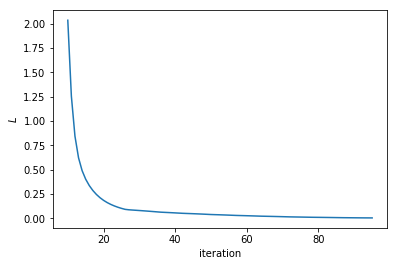

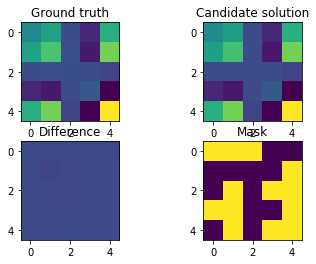

In [10]:
n = 5
p = 2
s = 13
# Generate random instance
M_sol = generate_matrix(n,p)
(M_sub,mask) = subsample_matrix(M_sol,s)
# Run gradient descent
(M,error,status) = gradient_descent_solver(M_sub,mask,p,10000)
# Plot the results
print status
plt.figure(1)
plt.plot(np.arange(10,np.size(error)),error[10:])
plt.xlabel('iteration')
plt.ylabel('$L$')
plt.figure(2)
plt.subplot(221)
plt.title('Ground truth')
plt.imshow(M_sol)
plt.subplot(222)
plt.title('Candidate solution')
plt.imshow(M,vmin=np.amin(M_sol),vmax=np.amax(M_sol))
plt.subplot(223)
plt.title('Difference')
plt.imshow(M-M_sol,vmin=np.amin(M_sol),vmax=np.amax(M_sol))
plt.subplot(224)
plt.title('Mask')
plt.imshow(mask)

Secondly, we study the influence of the number of observed values on the behavior of gradient descent.

In [11]:
def test(n,p,s,nb_its,nb_tests):
    # (n,p,s) = (matrix size, rank, number of observed values)
    # nb_its is the number of gradient descent steps
    # nb_tests is the number of tests
    counter = [0,0,0]
    for n_it in range(0,nb_tests):
        M = generate_matrix(n,p)
        (M_sub,mask) = subsample_matrix(M,s)
        (U,error,status) = gradient_descent_solver(M_sub,mask,p,nb_its)
        counter[status.value] = counter[status.value] + 1
    return counter

s =  10 -  12 -  14 -  16 -  18 -  20 -  22 -  24 -  26 -  28 -  30 -  32 -  34 -  36 -  38 - 

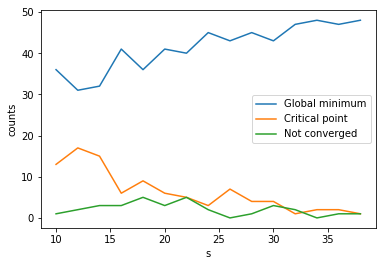

In [12]:
n = 9
p = 1
vals_s = range(10,40,2)
nb_s = len(vals_s)
counter = np.zeros((nb_s,3))
print('s = '),
for n_it in range(0,nb_s):
    s = vals_s[n_it]
    print(str(s) + ' - '),
    counter[n_it,:] = test(n,p,s,20000,50)
plt.xlabel('s')
plt.ylabel('counts')
plt.plot(vals_s,counter[:,convergence.GLOBAL_MINIMUM.value],label='Global minimum')
plt.plot(vals_s,counter[:,convergence.CRITICAL_POINT.value],label='Critical point')
plt.plot(vals_s,counter[:,convergence.NOT_CONVERGED.value],label='Not converged')
plt.legend()

## Additional questions

<ul>
<li>Perform tests for other values of $n,p$. How does the behavior of the algorithm vary with these parameters?</li>
<li>Play with the stepsize.</li>
<li>Implement an other optimization algorithm than gradient descent.</li>
<li>Show that, for any $U\in\mathbb{R}^{n\times p},G\in O(p)$, $L(UG)=L(U)$.</li>
<li>Compute all the critical points of $L$ when $s=n^2$. Is it in accordance with what you observe numerically? If not, why?</li>
<li>Same question when $s=1$.</li>
</ul>